# K-Nearest Neighbors Homework Solutions
***
**Name**: Poorwa Hirve (Identikey: pohi2375)
***

This assignment is due on Moodle by **5pm on Friday January 26th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

<br>

![Samples of Handwritten Digits](wide_mnist.png "MNIST Digits")


<br>

This homework is designed to be pretty easy. If you're spending a ton of time on this assignment, then you are either:

- not prepared to take this course (i.e., if you're struggling with Python)
- seriously over-thinking the assignment
- trying to implement too much of KNN from scratch


Most of this assignment will be done by calling libraries that are already implemented for you. If you are implementing $n$-dimensional search or your own distance metrics, you are generating extra work for yourself and making yourself vulnerable to errors. 

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1
***

The class below will load and store the MNIST data.  Load the data and then report: 
- The number of examples in the training set 
- The number of examples in the test set 
- The number of pixels in each image. 

In [2]:
class Numbers:
    """
    Class to store MNIST data
    """
    def __init__(self, location):

        import pickle, gzip

        # load data from file 
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

In [3]:
data = Numbers("../data/mnist.pklz")

In [4]:
# Printing the number of train examples
print ("Number of train examples:",len(data.train_y))

# Printing the number of test examples
print ("Number of test examples:",len(data.test_y))

# Printing the number of pixels in each image
print ("Number of pixels in each image:",len(data.train_x[0]))

Number of train examples: 50000
Number of test examples: 10000
Number of pixels in each image: 784


### [30 points] Problem 2
***

The class below will perform K-Nearest Neighbor classification on our handwritten digit data. Your tasks are as follows:   

1. Modify the `label_counts` function to return a dictionary of frequencies corresponding to each label in the training set. 
1. Modify the `majority` function so that it returns the _label_ that appears most frequently in the $K$-nearest neighbors of the query point.  In the case that the maximum frequency occurs for two or more labels, return the one that appears most frequently in the entire training set. In the case that there is still a tie, break the tie in any way that you choose. 
1. Modify the `classify` function so that it finds the _indices_ of the $K$ closest training examples to the query point and then calls the `majority` function to return the predicted label. Almost all of the heavy lifting here will be done by the BallTree object from `sklearn.neighbors`, so you'll want to start out by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).  
1. Modify the `confusion_matrix` function to classify examples and record the results in a confusion matrix. You should construct the confusion matrix on your own.  Don't call any additional functions from sklearn to do it for you.

The class Knearest also implements an `accuracy` function which you will use in **Problem 3**.  You should not have to modify this function. 

We've given you unit tests down below based on the simple example worked out in lecture.  At first your code will fail all of them.  Do not move on to **Problem 3** until your code passes all of the unit tests. In addition, passing the unit tests does not guarantee that your implementation is robust and that you'll earn full points on this problem.  You should be designing your own additional tests as well. 

In [24]:
class Knearest:
    """
    kNN classifier
    """

    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance

        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """
        
        from sklearn.neighbors import BallTree
        self._X = X
        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
    def label_counts(self):
        """
        Given the training labels, return a dictionary d where d[y] is  
        the number of times that label y appears in the training set. 
        """
        
        unique, counts = np.unique(self._y, return_counts=True)
        #print ("Printing counts")
        #print (counts)
        #print ("Printing counts dict")
        counts_dictionary = dict(zip(unique, counts))
        
        #print (counts_dictionary)
        
        return counts_dictionary

    def majority(self, neighbor_indices):
        """
        Given the indices of training examples, return the majority label. Break ties 
        by choosing the tied label that appears most often in the training data. 

        :param neighbor_indices: The indices of the k nearest neighbors
        """
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"
               
        label_list = []

        for indices in neighbor_indices:
            label_list.append(self._y[indices])
        
        #print (label_list)
        
        import collections
        
        c = collections.Counter(label_list)
        
        #print (c)
        
        #max_counts = c[label_list[0]]
        output_label = label_list[0]
        
        for label in c.keys():
            #print ("Label:", label, "with count:", c[label], "compared to MAX = ", max_counts)
            if c[label] > c[output_label]:
                #print ("Count of",label,"is greater than count of",output_label)
                output_label = label
                
            elif c[label] == c[output_label]:
                if self._counts[label] > self._counts[output_label]:
                    #print ("Self Count of",label,"is greater than count of",output_label)
                    output_label = label

                    
        return output_label

    def classify(self, example):
        """
        Given an example, return the predicted label. 

        :param example: A representation of an example in the same
        format as a row of the training data
        """
        
        new_example = example.reshape(1, -1)
        neighbor_distance, neighbor_indices = self._kdtree.query(new_example, k=self._k)
        
        
        #print (self.majority(neighbor_indices[0]))
            
        return self.majority(neighbor_indices[0])



    def confusion_matrix(self, test_x, test_y):
        """
        Given a matrix of test examples and labels, compute the confusion
        matrix for the current classifier.  Should return a 2-dimensional
        numpy array of ints, C, where C[ii,jj] is the number of times an 
        example with true label ii was labeled as jj.

        :param test_x: test data 
        :param test_y: true test labels 
        """

        # True test labels -> yy -> rows of C
        # Predicted labels -> pred_y -> columns of C
        
        C = np.zeros((len(self._counts), len(self._counts)))
        for xx, yy in zip(test_x, test_y):
            pred_y = self.classify(xx)
            C[yy][pred_y] += 1

        
        return C
        
    @staticmethod
    def accuracy(C):
        """
        Given a confusion matrix C, compute the accuracy of the underlying classifier.
        
        :param C: a confusion matrix 
        """
        
        return np.sum(C.diagonal()) / C.sum()


Here are the unit tests.  You don't need to modify them.  Simply execute the cell and observe the output. 

In [25]:
import unittest

class TestKnn(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[2, 0], [4, 1], [6, 0], [1, 4], [2, 4], [2, 5], [4, 4], [0, 2], [3, 2], [4, 2], [5, 2], [5, 5]])
        self.y = np.array([+1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1])
        self.knn = {}
        for ii in [1, 2, 3]:
            self.knn[ii] = Knearest(self.x, self.y, ii)

        self.queries = np.array([[1, 5], [0, 3], [6, 4]])
        
    def test0(self):
        """
        Test the label counter 
        """
        self.assertEqual(self.knn[1]._counts[-1], 5)
        self.assertEqual(self.knn[1]._counts[1], 7)

    def test1(self):
        """
        Test 1NN
        """
        self.assertEqual(self.knn[1].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[1].classify(self.queries[1]), -1)
        self.assertEqual(self.knn[1].classify(self.queries[2]), -1)

    def test2(self):
        """
        Test 2NN
        """
        self.assertEqual(self.knn[2].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[2]),  1)

    def test3(self):
        """
        Test 3NN
        """
        self.assertEqual(self.knn[3].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[2]), -1)
        
tests = TestKnn()
tests_to_run = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(tests_to_run)

....
----------------------------------------------------------------------
Ran 4 tests in 0.008s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### [15 points] Problem 3
***

In this problem you'll explore the performance of the classifier you've written.  A word of advice: don't use the entire training set, especially at first.  We'll be using this dataset again later on with techniques that scale better.    

**Part A**: Explore the relationship between the number of training examples and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

In [9]:
x_plot_train_1 = [x for x in range(500,50000,5000)]
y_plot_train_1 = []
test_x = data.test_x
test_y = data.test_y
for train_sets in x_plot_train_1:
    train_x = data.train_x[:train_sets]
    train_y = data.train_y[:train_sets]
    knn = Knearest(train_x, train_y, 1)
    C = knn.confusion_matrix(test_x, test_y)
    y_plot_train_1.append(knn.accuracy(C))

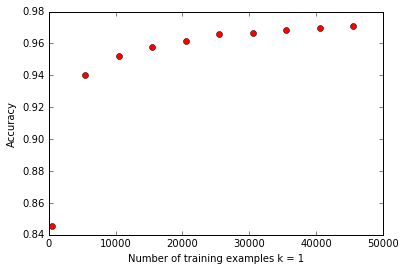

In [46]:
plt.plot(x_plot_train_1, y_plot_train_1, 'ro')
plt.xlabel('Number of training examples k = 1')
plt.ylabel('Accuracy')
plt.show()

In [11]:
x_plot_train_3 = [x for x in range(500,50000,5000)]
y_plot_train_3 = []
test_x = data.test_x
test_y = data.test_y
for train_sets in x_plot_train_3:
    train_x = data.train_x[:train_sets]
    train_y = data.train_y[:train_sets]
    knn = Knearest(train_x, train_y, 3)
    C = knn.confusion_matrix(test_x, test_y)
    y_plot_train_3.append(knn.accuracy(C))

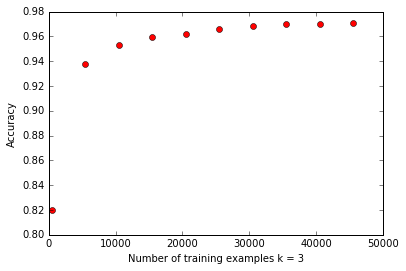

In [47]:
plt.plot(x_plot_train_3, y_plot_train_3, 'ro')
plt.xlabel('Number of training examples k = 3')
plt.ylabel('Accuracy')
plt.show()

**Solution:**

**Relationship between number of training examples and accuracy on test set**: The relationship shows that with the increase in training examples, accuracy on the test set increases. With k = 1, as the number of training samples increases, accuracy increases sharply at first then stablizes with very slight increase. With k = 3, the accuracy increases sharply at first then stabilizes at around 97%.

**Part B**: Explore the relationship between the number of nearest neighbors and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

In [13]:
x_plot_k = [x for x in range(1,22,2)]
y_plot_k = []
test_x = data.test_x
test_y = data.test_y
train_x = data.train_x
train_y = data.train_y
for k in x_plot_k:
    knn = Knearest(train_x, train_y, k)
    C = knn.confusion_matrix(test_x, test_y)
    y_plot_k.append(knn.accuracy(C))

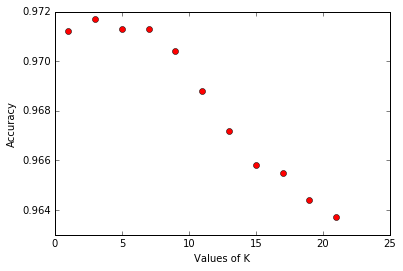

In [14]:
plt.plot(x_plot_k, y_plot_k, 'ro')
plt.xlabel('Values of K')
plt.ylabel('Accuracy')
plt.show()

**Solution:**

**Relationship between number of nearest neighbors and accuracy on test set**: The relationship shows that with the increase in nearest neighbors, accuracy on the test set decreases. This is because as k increases, the number of nearest neighbors increases which causes irregularities in predicting the digit, leading to decrease in accuracy. K = 3 is seen to be the best value of k as it gives the maximum accuracy on the test data.

**Part C**: Which numbers get confused with each other the most easily?  Use the confusion_matrix function that you wrote above to support your conclusion.  Then use the `view_digit` function given below to plot a few examples of misclassified digits and discuss possible reasons for the misclassifications.  (Investigating misclassified examples is called **error analysis** and is an important step in the development of any classification technique).  

In [54]:
knn = Knearest(data.train_x, data.train_y, 3)
C = knn.confusion_matrix(data.test_x, data.test_y)

In [57]:
# Rows are the actual values; Columns are the predicted values
print ('A\P|\t0\t1\t2\t3\t4\t5\t6\t7\t8\t9')
print ('------------------------------------------------------------------------------------')
for i in range(len(knn._counts)):
    print (str(i) + ":", end='\t')
    for j in range(10):
        print (int(C[i][j]), end='\t')
    print()
    
print ("\nAccuracy of KNN with k = 3:",knn.accuracy(C)*100)

A\P|	0	1	2	3	4	5	6	7	8	9
------------------------------------------------------------------------------------
0:	982	0	3	0	0	0	2	1	1	2	
1:	0	1060	1	0	1	0	1	1	0	0	
2:	3	8	952	3	1	1	1	20	1	0	
3:	0	0	4	1005	0	8	1	3	6	3	
4:	0	11	0	0	949	0	0	4	0	19	
5:	2	0	2	20	1	867	16	3	1	3	
6:	1	1	0	0	0	1	964	0	0	0	
7:	0	10	0	0	2	0	0	1072	0	6	
8:	2	8	2	15	3	14	5	6	947	7	
9:	2	3	0	11	11	3	0	10	2	919	

Accuracy of KNN with k = 3: 97.17


In [64]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(28,28), cmap='gray');

confused = []
confused_i = []
y_preds = []
i = 0
j = 0
done = []
for xx, yy in zip(data.test_x, data.test_y):
    pred_y = knn.classify(xx)
    check = str(yy) + str(pred_y)
    if pred_y != yy and C[yy][pred_y] >= 15 and check not in done:
        confused.append(xx)
        confused_i.append(yy)
        y_preds.append(pred_y)
        done.append(check)
        i += 1
        if i == 5:
            break

true label: 4
predicted label: 9


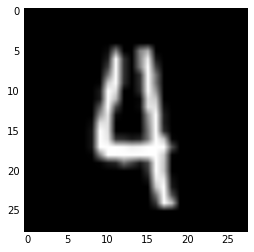

In [65]:
view_digit(confused[0], confused_i[0])
print ("predicted label:",y_preds[0])

true label: 2
predicted label: 7


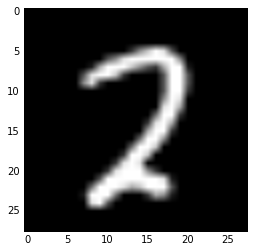

In [66]:
view_digit(confused[1], confused_i[1])
print ("predicted label:",y_preds[1])

true label: 8
predicted label: 3


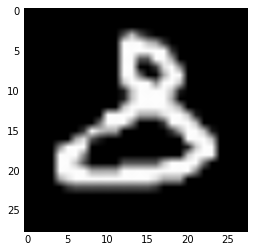

In [67]:
view_digit(confused[2], confused_i[2])
print ("predicted label:",y_preds[2])

true label: 5
predicted label: 3


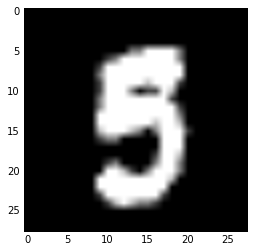

In [68]:
view_digit(confused[3], confused_i[3])
print ("predicted label:",y_preds[3])

true label: 5
predicted label: 6


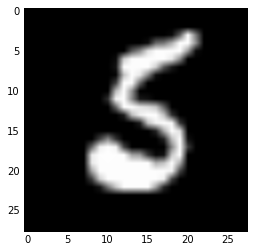

In [69]:
view_digit(confused[4], confused_i[4])
print ("predicted label:",y_preds[4])

**Solution:** 

The plots of the above digits show that the shape of the handwritten digits make the knn model confused as to which number it actually is. The first 2 strongly resembles a 7 due to its shape, similarly 4 resembles a 9 and so on. This error in classification occurs due to the way the digits have been written such that their pixel values and thus nearest neighbors influence the decision to classify as a wrong digit.

The confusion matrix supports this as can be seen at the indices 4 and 9 for actual and predicted values C[4][9] where 19 test samples which are actually digit 4 have been misclassified as 9, and for 2 and 7 where C[2][7] = 20.